In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import modeling
print(modeling.__version__)

0.0.1.dev0


In [3]:
import numpy as np
import matplotlib.pyplot as pl

from modeling import ModelMixin, Parameter, parameter_sort

/Users/dfm/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):
/Users/dfm/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


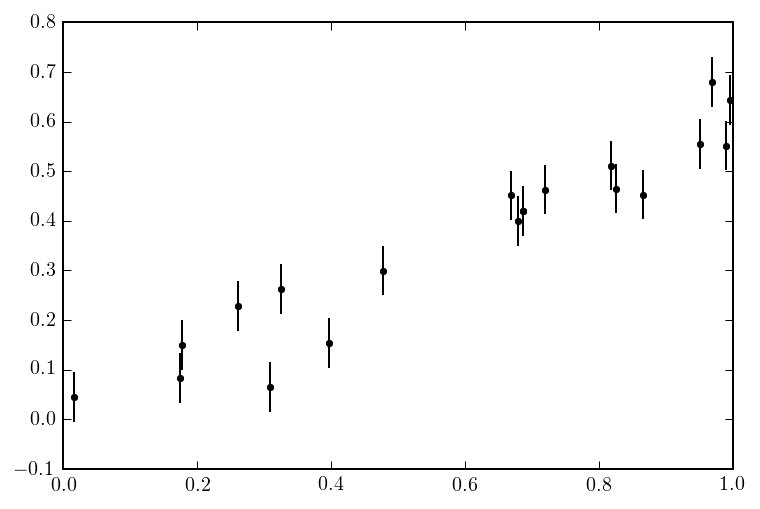

In [4]:
x = np.random.rand(20)
yerr = 0.05 + np.zeros_like(x)
y = 0.5 * x + 0.05 + np.sqrt(yerr**2 + 0.05**2) * np.random.randn(len(x))

pl.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0);

In [5]:
class Model(ModelMixin):
    
    m = Parameter()
    b = Parameter()
    log_sigma = Parameter()
    
    sigma = Parameter(depends=log_sigma)
    @sigma.getter
    def get_sigma(self):
        return np.exp(self.log_sigma)
    
    @sigma.setter
    def set_sigma(self, value):
        self.log_sigma = np.log(value)
        
    def __init__(self, x, y, yerr, **kwargs):
        self.x = x
        self.y = y
        self.yvar = yerr ** 2
        
        super(Model, self).__init__(**kwargs)
        
    def get_value(self):
        var = self.yvar + self.sigma**2
        delta = self.y - (self.m * self.x + self.b)
        return -0.5 * np.sum(delta**2 / var + np.log(var))
    
    @parameter_sort
    def get_value_and_gradient(self):
        var = self.yvar + self.sigma**2
        delta = self.y - (self.m * self.x + self.b)
        value = -0.5 * np.sum(delta**2 / var + np.log(var))
        
        return value, dict(
            m=np.dot(self.x, delta / var),
            b=np.dot(np.ones(len(self.x)), delta / var),
            log_sigma=self.sigma**2*np.sum(delta**2/var**2 - 1.0 / var)
        )

In [16]:
model = Model(x, y, yerr, m=0.2, b=0.0, log_sigma=0.1)

In [17]:
model.test_gradient()

True

In [18]:
from scipy.optimize import minimize

In [19]:
def nll(p):
    model.set_vector(p)
    v, g = model.get_value_and_gradient()
    return -v, -g

r = minimize(nll, model.get_vector(), jac=True)

In [20]:
r

  message: 'Optimization terminated successfully.'
   status: 0
        x: array([ 0.59939024,  0.0058301 , -3.92165654])
      nit: 16
  success: True
      jac: array([  7.64880030e-06,   1.01701390e-06,  -9.33718073e-08])
      fun: -48.45680066914205
     nfev: 29
 hess_inv: array([[  1.96555921e-03,  -1.12492532e-03,   9.69107064e-04],
       [ -1.12492532e-03,   7.91058482e-04,  -8.25411090e-04],
       [  9.69107064e-04,  -8.25411090e-04,   1.32054201e+00]])
     njev: 29